# Attitude determination

## october campaign

### load data from logs

In [13]:
date='2021-18-17'
import os
import pandas as pd
#aug1=pd.read_csv(indir+date+'/hk_data_decoded.txt',delimiter='\t')
oct1=pd.read_csv("/home/limu/Space/logs/alpha/hk_data_october_14.txt",delimiter='\t')
oct1.columns

Index(['RealTimeStamp', 'DK EpochTimeStamp [s]', 'DK TimeStamp', 'CunkID',
       'ChunkType', 'Length [B]', 'LdSt magX [nT]', 'LdSt magY [nT]',
       'LdSt magZ [nT]', 'LdStTot [nT]', 'OBC magX [nT]', 'OBC magY [nT]',
       'OBC magZ [nT]', 'OBCtot [nT]', 'OBC_9DOF_Temp [*C]',
       'OBCgyroX [deg/s]', 'OBCgyroY [deg/s]', 'OBCgyroZ [deg/s]',
       'OBCaccX [mG]', 'OBCaccY [mG]', 'OBCaccZ [mG]', 'SolT X+ [*C]',
       'SolT Y+ [*C]', 'SolT X- [*C]', 'SolT Y- [*C]', 'SolT Z- [*C]',
       'OBC_Temp [*C]', 'ssTemp(X+) [*C]', 'ssTemp(Y+) [*C]',
       'ssTemp(X-) [*C]', 'ssTemp(Y-) [*C]', 'ssTemp(Z-) [*C]', 'ssIRRad(X+)',
       'ssIRRad(Y+)', 'ssIRRad(X-)', 'ssIRRad(Y-)', 'ssIRRad(Z-)',
       'ssAngleX (X+) [deg]', 'ssAngleY (X+) [deg]', 'ssAngleX (Y+) [deg]',
       'ssAngleY (Y+) [deg]', 'ssAngleX (X-) [deg]', 'ssAngleY (X-) [deg]',
       'ssAngleX (Y-) [deg]', 'ssAngleY (Y-) [deg]', 'ssAngleX (Z-) [deg]',
       'ssAngleY (Z-) [deg]', 'ssGyroX (X+) [deg/s]', 'ssGyroY (X+) [deg/s

In [14]:
mok=oct1
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
from datetime import datetime,timedelta
mags=np.array([np.array(mok[mok.columns[6+i]]) for i in range(3)]).T
mags=mags[1:-1]
times=[datetime.strptime(m,"%d-%m-%Y %H:%M:%S") for m in mok['DK TimeStamp']]
dt=np.array([(t-times[0]).seconds for t in times])


#### angles and gyros

set of five 2axis datas from gyro sensors on Lode modules (really? Lode has 3-axis gyro)

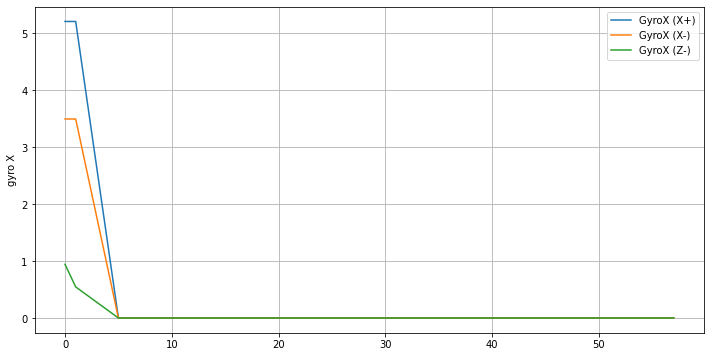

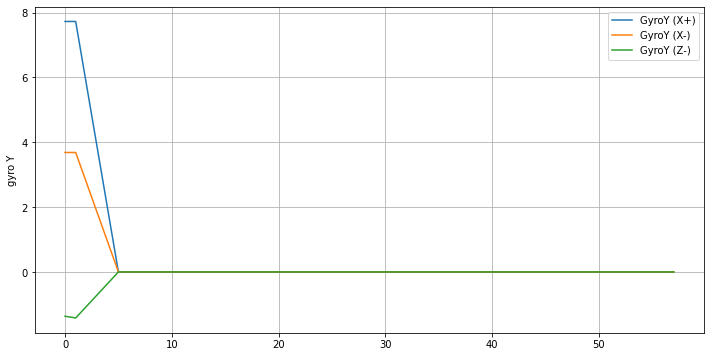

In [15]:
pl.figure(figsize=(12,6))
[pl.plot(dt,mok[c],label=c[2:-8]) for c in mok.columns[-10::4]]#[-9::2]
pl.ylabel("gyro X")
pl.legend()
pl.grid()
pl.figure(figsize=(12,6))
pl.ylabel("gyro Y")
[pl.plot(dt,mok[c],label=c[2:-8]) for c in mok.columns[-9::4]]
pl.legend()
pl.grid()

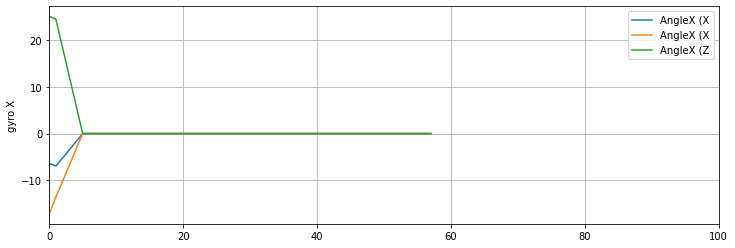

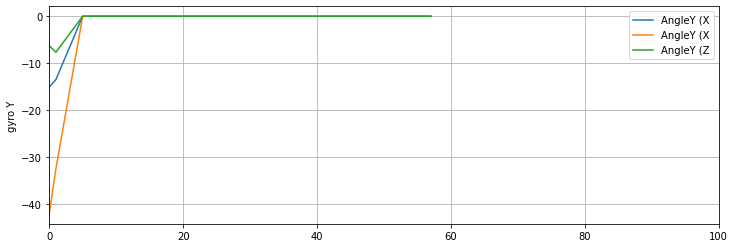

In [16]:
tmax=100
pl.figure(figsize=(12,4))
[pl.plot(dt,mok[c],label=c[2:-8]) for c in mok.columns[-10-10:-10:4]]#[-9::2]
pl.ylabel("gyro X")
pl.legend()
pl.xlim(0,tmax)
pl.grid()
pl.figure(figsize=(12,4))
pl.ylabel("gyro Y")
[pl.plot(dt,mok[c],label=c[2:-8]) for c in mok.columns[-9-10:-10:4]]
pl.legend()
pl.xlim(0,tmax)
pl.grid()

In [17]:
## no 
geero=[i for i,m in enumerate(mok.columns) if m.find('OBCgyro')>=0]
[mok[mok.columns[i+3]].std() for i in geero] #no data here
#pl.plot(dt,mok[mok.columns[geero[2]]]) 

[0.0, 0.0, 0.0]

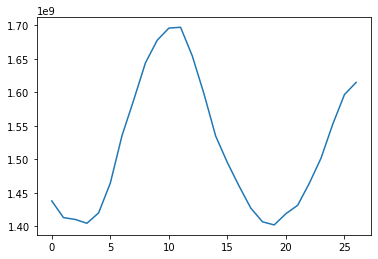

In [18]:
pl.plot((mags**2).sum(1))

Text(0.5, 1.0, 'Solar panel temps')

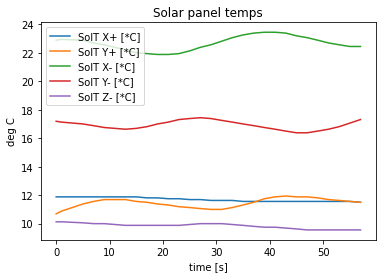

In [19]:
tpanel=np.array([mok[c].to_numpy() for c in [mok.columns[i] for i in range(21,26)]])
[pl.plot(dt,t) for t in tpanel]
pl.legend([mok.columns[i] for i in range(21,26)])
pl.ylabel("deg C")
pl.xlabel("time [s]")
pl.title("Solar panel temps")

Text(0.5, 1.0, 'SunSensor temps')

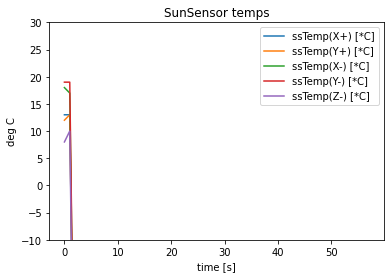

In [20]:
tpanel=np.array([mok[c].to_numpy() for c in [mok.columns[i] for i in range(27,32)]])
[pl.plot(dt,t) for t in tpanel]
pl.legend([mok.columns[i] for i in range(27,32)])
pl.ylim(-10,30)
pl.ylabel("deg C")
pl.xlabel("time [s]")
pl.title("SunSensor temps")

In [21]:
irpos=[i for i in range(len(mok.columns)) if mok.columns[i].find("IRR")>0]
rep=[]
qth = (48.7408,-21.2284,380)
from astropy import coordinates as coord
from astropy import units as u
import predict
tle= """GRBALPHA                
1 47959U 21022AD  22063.19213865  .00002067  00000+0  14319-3 0  9994
2 47959  97.5413 324.9761 0022167 141.3192  11.3230 15.06545409 50965"""
pars=['longitude','latitude','altitude','epoch']
kosice=coord.EarthLocation.from_geodetic(qth[1],-qth[0],qth[2])#,unit=(u.degree, u.degree,u.meter))
kosrad=np.sqrt(sum(np.array(kosice.value.tolist())**2))*1e-3 #earth distance in km

for d in mok['DK TimeStamp']:
    x=datetime.strptime(d,"%d-%m-%Y %H:%M:%S")
    y=predict.observe(tle, qth, at=x.timestamp())
    rep.append([y['longitude'],y['latitude'],y['altitude']])
rep=np.array(rep).T
if rep[0].max()-rep[0].min()>200:rep[0]=(rep[0]+180)%360-180

In [22]:
from periodogram import get_mag_dir

pomag=[]
for i in [0,len(rep)-1]:
    day=mok['DK TimeStamp'][i].split(' ')[0]
    day='-'.join(day.split('-')[::-1])
    pomag.append(get_mag_dir(day,rep[1][i],rep[0][i],rep[2][i]))
    
pom1,pom2=pomag[0],pomag[-1]
vecs=[np.array([dic[t+'-intensity'] for t in ['east','north','vertical']]) for dic in pomag]#'declination'] 
norm=lambda v:np.sqrt(np.dot(v,v))
nvecs=[v/norm(v) for v in vecs]
nvecs

[array([-0.29874462,  0.1213903 , -0.94658124]),
 array([-0.29921617,  0.12432882, -0.94605075])]

In [23]:
satcoor2=[coord.EarthLocation.from_geodetic(r[0],r[1],r[2]*1e3) for r in rep.T] 
import periodogram as pg
sunvec_hall=np.array([pg.sun_vec_CHall(t) for t in times])

In [24]:
all_rot=[]
from satutils import triad
dtot=dt[-1]
magdir=[coord.SkyCoord(pomag[i]['inclination'],pomag[i]['declination'],unit="deg",frame="altaz",location=satcoor2[i],obstime=times[i]) for i in [0,-1]]
magvec=[np.array([c.x.value,c.y.value,c.z.value]) for c in [m.fk5.cartesian for m in magdir]]
magvec=[m/norm(m) for m in magvec]
mag_inter = lambda t:(t/dtot*magvec[1]+(1-t/dtot)*magvec[0])



In [25]:
## prediction of Sun direction in body frame?

print(np.array([sunvec_hall[i] for i in [1,10,-1]])) # in ECI
#from astropy.coordinates import get_body_barycentric, get_body, get_sun, EarthLocation
from astropy.time import Time
sunvec_apy=[]  #coord.get_sun(Time(t)) for j,t in enumerate(times)]
#for j,s in enumerate(sunvec_apy):
for j in range(len(times)):
    loc=coord.EarthLocation.from_geodetic(rep[0][j],rep[1][j],rep[2][j]*1e3)
    sunvec_apy.append(coord.get_sun(time=Time(times[j])))
    sunvec_apy[-1].location=loc
    #print(rep[0][j],rep[1][j])
import satutils as su
sunvec_loc=[su.fromangle(s.altaz.az.value,s.altaz.alt.value) for s in sunvec_apy]
sunvec_eci=[su.fromangle(s.ra.value,s.dec.value) for s in sunvec_apy]
np.array([sunvec_eci[i] for i in [1,10,-1]])

[[-0.81864941 -0.5269154  -0.22841478]
 [-0.81864714 -0.52691837 -0.22841606]
 [-0.81864305 -0.52692371 -0.22841838]]


array([[-0.93382379, -0.32822116, -0.14228142],
       [-0.93382236, -0.32822458, -0.14228291],
       [-0.93381978, -0.32823075, -0.14228559]])

In [26]:
j=0
coo=coord.AltAz(0*u.deg,-90*u.deg,obstime=times[j], location=satcoor2[j])
coo.obstime.location=coo.location
tm=coo.obstime.sidereal_time('mean')
sco=coord.SkyCoord(coo)#,frame='altaz')
nadir=sco
sco.icrs, rep[:,j],tm.deg,sco.separation(sunvec_apy[j]).deg

(<SkyCoord (ICRS): (ra, dec) in deg
     (53.10496878, 64.9124025)>,
 array([ 66.67902614, -64.9832197 , 560.35026465]),
 233.59859022925704,
 118.54175281151167)

In [27]:
sco.separation(sunvec_apy[j]).deg

118.54175281151167

In [28]:
coo.obstime.location=coo.location
tm=coo.obstime.sidereal_time('mean')
tm.deg

233.59859022925704

### finding proper sun direction

- fix the magnetic field direction
- est. angle between sun and magnet
- vary "azimuth" of sun vector to fit best the observation

In [31]:
angle=[np.arccos(np.dot(mag_inter(dt[i]),sunvec_hall[i])) for i in range(len(dt))]
#pl.plot(np.rad2deg(angle))
angle2=np.array([np.arccos(np.dot(mag_inter(dt[i]),sunvec_eci[i])) for i in range(len(dt))])
angle=np.mean(angle) #changes negligeable
print(np.rad2deg(np.max(angle2)-np.min(angle2)))
print(np.rad2deg((np.max(angle2)+np.min(angle2))/2))
#angle2=np.mean(angle2)
#np.rad2deg(angle),np.rad2deg(angle2)

3.0750366909823383
100.91114256054958


In [32]:
angle2.min()-angle2.max()

-0.05366951487727323

In [33]:
mbody=[m/norm(m) for m in mags]
phi=np.r_[:2*np.pi:40j]
j=3
wee=np.array([np.cos(angle2[j]),np.sin(angle2[j])*np.cos(phi[j]),np.sin(angle2[j])*np.sin(phi[j])])

In [34]:
rmatx=triad(mbody[j],[0,0,1])
sun_ex=rmatx.T@wee
np.rad2deg(np.arccos(np.dot(sun_ex,mbody[j])))

99.74961173134136

In [35]:
rmatx@mbody[-1]

array([ 0.83118212, -0.32383498, -0.45195928])

calculate Sun direction in body (satellite) coordinate frame (for all possible rotations perpendicular to magnetic field):

/tmp/ipykernel_82036/1055935684.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  awee=np.array([np.cos(angle2[j]),np.sin(angle2[j])*np.cos(phi),np.sin(angle2[j])*np.sin(phi)])#


Text(0.5, 0, 'rotation (roll) angle')

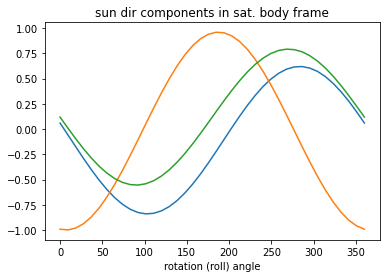

In [36]:
#np.allclose(rmatx.T@rmatx,np.eye(3)) # rmatx is orthonormal
j=0
awee=np.array([np.cos(angle2[j]),np.sin(angle2[j])*np.cos(phi),np.sin(angle2[j])*np.sin(phi)])#
asun=rmatx.T@awee # in body frame
[pl.plot(np.rad2deg(phi),s) for s in asun]
pl.title("sun dir components in sat. body frame")
pl.xlabel("rotation (roll) angle")

#### similar for Earth (as light source) 

In [84]:
#[a for a in nadir.fk5.cartesian]
nadir_eci=su.eloc2cart(nadir.fk5.cartesian)
i=0
np.rad2deg(np.arccos(np.dot(mag_inter(dt[i]),nadir_eci))),np.rad2deg(np.arccos(np.dot(sunvec_eci[i],nadir_eci)))

(102.87580747190029, 62.06831931582425)

### try some model

we don't have much details about the sensor from [NEEDRONIX](https://sunsensor.eu/NXSS3v00.html)

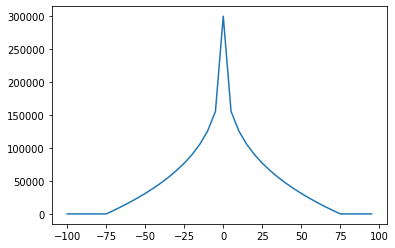

In [37]:
amp=3e5
mang=75
zex=0.27
viewang=lambda ang:(abs(ang)<mang)*(1-(abs(ang)/mang)**zex)*amp
angs=np.r_[-100:100:5]
pl.plot(angs,[viewang(a) for a in angs])

#### simulate SunSensor signal for different roll angle

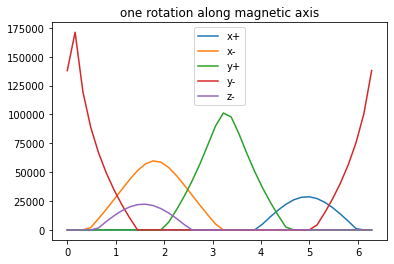

In [38]:
def predict_roll(asun):
    xp,xm=viewang(np.rad2deg(np.arccos(asun[0]))),viewang(180-np.rad2deg(np.arccos(asun[0])))
    yp,ym=viewang(np.rad2deg(np.arccos(asun[1]))),viewang(180-np.rad2deg(np.arccos(asun[1])))
    zm=viewang(180-np.rad2deg(np.arccos(asun[2])))
    return xp,yp,xm,ym,zm
xp,yp,xm,ym,zm=predict_roll(asun)
pl.plot(phi,xp,phi,xm)
pl.plot(phi,yp,phi,ym)
pl.plot(phi,zm)
pl.title("one rotation along magnetic axis")
pl.legend("x+ x- y+ y- z-".split())

In [39]:
tle_all=open("/home/limu/Code/Notebook/Astro/alpha/ephem/tle_all.txt").readlines()
tle_arr=[tle_all[4*i+1].replace('-','.').replace('+','.').split()[3:]+tle_all[4*i+2].replace('-','.').split()[2:] for i in range(len(tle_all)//4)]

In [40]:
tle_grb=''.join([t[30:] for t in tle_all[-3:]])
tle_grb='''GRBALPHA
1 47959U 21022AD  22089.06574127  .00004075  00000-0  27671-3 0  9996
2 47959  97.5376 350.3030 0022746  59.5456 300.8062 15.06733026 54867'''
now=datetime.now()
trans=predict.transits(tle_grb,qth,now.timestamp(),(now+timedelta(0,1e6)).timestamp())
trans=[t for t in trans if t.peak()['elevation']>10]

In [41]:
from datetime import timezone#.utc as utc
timezone.utc
#now.tzinfo
#timezone.timezone('Europe/Prague')
t=trans[2]
datetime.fromtimestamp(t.start,timezone.utc)#.tzinfo

datetime.datetime(2022, 4, 29, 8, 26, 4, 352789, tzinfo=datetime.timezone.utc)

In [42]:
times=[[datetime.fromtimestamp(tx,timezone.utc).isoformat()[:19].replace('T',' ') for tx in [t.start,t.peak()['epoch'],t.end]] for t in trans]

In [43]:
gpos=lambda p:[p["longitude"],p["latitude"]]
zpos=[gpos(t.peak()) for t in trans]
zpos[:10]

[[25.044256817121518, 48.185259473748125],
 [3.2277770595296182, 53.36699251342964],
 [25.77575048161929, 49.58977838023303],
 [2.696120413847158, 47.36530951347621],
 [26.418931021417958, 48.01950238984543],
 [4.472175807871653, 52.93262390419122],
 [27.10142490714892, 49.87818549020867],
 [4.1358806555225005, 47.35861498219621],
 [27.80250293214258, 47.871877039486456],
 [5.728466584142264, 52.51367556969185]]

### statistics of other HK data

In [44]:
import pickle
irnorm=pickle.load(open("coramp.pkz","rb"))

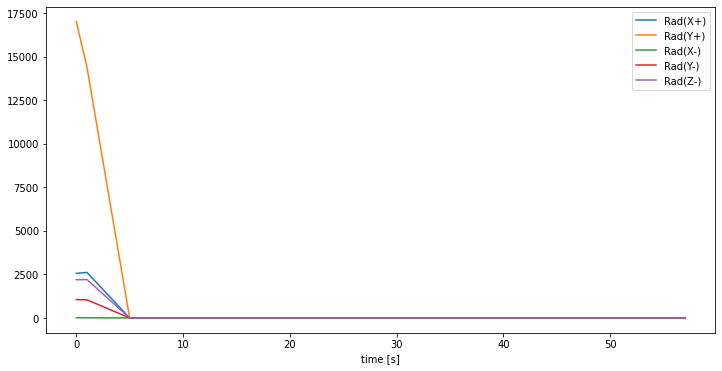

In [47]:
fig=pl.figure(figsize=(12,6))
irsens=np.array([mok[c].to_numpy() for c in [mok.columns[i] for i in irpos]])
pl.xlabel("time [s]")
[pl.plot(dt,s) for s in irsens]
pl.legend([mok.columns[i][4:] for i in irpos])
pl.savefig("/home/limu/Space/logs/alpha/sunsens_october2.png")

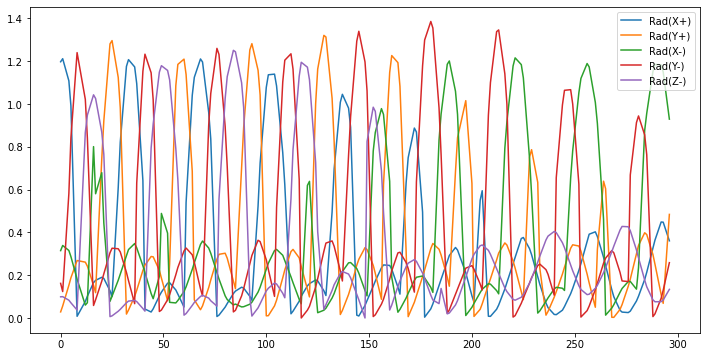

In [71]:
irsens2=irsens*2/(irnorm[:,0]+irnorm[:,1])[:,np.newaxis]
fig=pl.figure(figsize=(12,6))
[pl.plot(dt,s) for s in irsens2]
pl.legend([mok.columns[i][4:] for i in irpos])

[[<matplotlib.lines.Line2D at 0x7fb57e600280>],

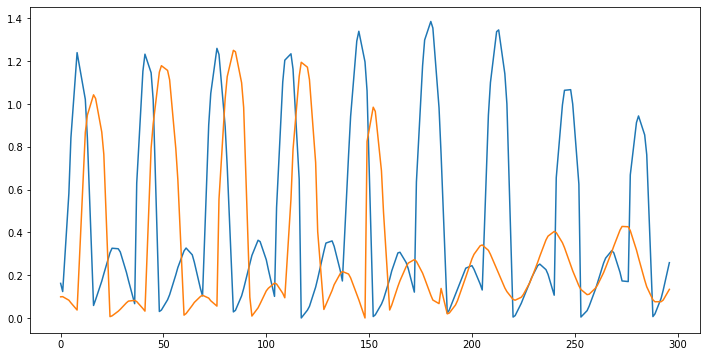

In [73]:
fig=pl.figure(figsize=(12,6))
[pl.plot(dt,s) for s in irsens2[-2:]]

(0.0, 120.0)

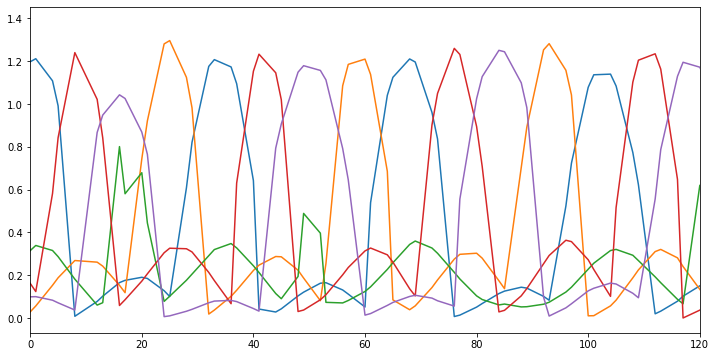

In [52]:
fig=pl.figure(figsize=(12,6))
[pl.plot(dt,s) for s in irsens2]
pl.xlim(0,120)

### rotating model vs. reality

Text(0, 0.5, 'simulated')

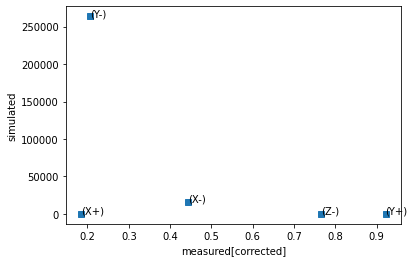

In [140]:
labels=[mok.columns[i][7:] for i in irpos]
simu=np.array([xp,yp,xm,ym,zm])
k=10
pl.plot(irsens2[:,k],simu[:,2],'s')
for i in range(5):
    pl.text(irsens2[i,k],simu[i,2],labels[i])
np.corrcoef(irsens2[:,k],simu[:,2])[0][1]
pl.xlabel("measured[corrected]")
pl.ylabel("simulated")
#pl.plot(phi,xp,phi,xm)
#pl.plot(phi,yp,phi,ym)
#pl.plot(phi,zm)

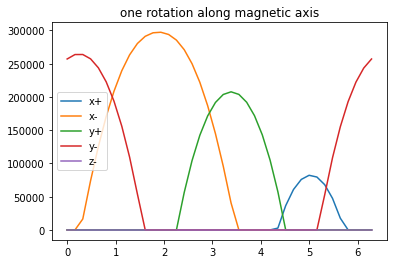

In [143]:
pl.plot(phi,xp,phi,xm)
pl.plot(phi,yp,phi,ym)
pl.plot(phi,zm)
pl.title("one rotation along magnetic axis")
pl.legend("x+ x- y+ y- z-".split())

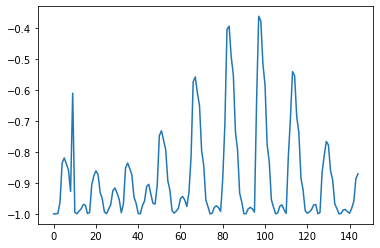

In [231]:
aliad=[triad(m,[0,0,1]) for m in mbody]
pl.plot([a[1][1] for a in aliad])

In [246]:
#swee=awee[:,2]
#zwee=[m.T@swee for m in aliad]#for i in range(len(times))]
len(good_angs)
#irsens2.std(0)

147

In [255]:
simu.std(0)

array([108248.55505443, 114765.50939151, 117803.66228751, 117064.21421153,
       110511.21466979, 104460.00366949,  95978.3853802 ,  83472.45201274,
        76973.10893074,  78239.7045157 ,  88103.82982521,  99282.5496293 ,
       102143.31423841, 102496.44628603, 100920.51163369,  93131.21956896,
        94933.9374527 ,  99546.8619551 , 101154.99505547, 101856.30647575,
       101620.04340883, 101164.84670523, 101782.69098081, 101923.10821384,
        96107.50417612,  86723.86239288,  73449.84163133,  55982.68878218,
        34721.23897973,  35704.9271421 ,  50633.28543024,  60940.28905195,
        67892.85820315,  70373.88065507,  71730.26969565,  78702.27021436,
        87237.31475909,  95238.41831187, 102112.18432621, 108248.55505443])

failed 145
failed 146


Text(0, 0.5, 'roll angle[deg]')

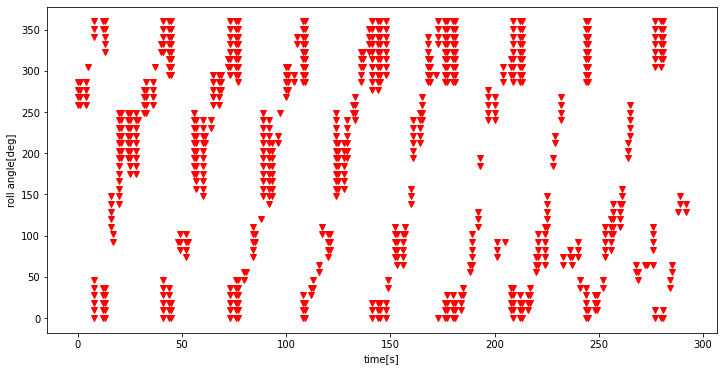

In [ ]:
pl.figure(figsize=(12,6))
dphi=np.rad2deg(phi)
rmatx=triad(mbody[3],[0,0,1])
good_angs=[]
for i in range(len(times)):
    awee=np.array([np.cos(angle2[i])*np.ones_like(phi),np.sin(angle2[i])*np.cos(phi),np.sin(angle2[i])*np.sin(phi)])# sun dir in EQ frame
    #rmatx=triad(mbody[i],[0,0,1])
    try:
        asun=aliad[i].T@awee # in body frame
        simu=np.array(predict_roll(asun))
    except:
        print(f"failed {i}")
        good_angs.append([])
        continue
    prof1=[np.corrcoef(irsens2[:,i],s)[0][1] if s.std()>100 else 0 for s in simu.T]
    prof1=np.array(prof1)
    pind=np.where(prof1>=0.95*prof1.max())[0]
    pl.plot(dt[i]*np.ones_like(pind),dphi[pind],'rv')
    good_angs.append(dphi[pind])
pl.xlabel("time[s]")
pl.ylabel("roll angle[deg]")

In [185]:
phi0=good_angs[0].mean()
timsel=np.array([dt[i] for i in range(len(good_angs)) if np.any((good_angs[i]>200)*(good_angs[i]<210))])
ind_pass=np.where(timsel[1:]-timsel[:-1]>20)[0]+1
tpass=timsel[ind_pass]
period=(tpass[1:]-tpass[:-1]).mean()
phi0,period

(276.92307692307696, 34.833333333333336)

In [194]:
tpass[1:]-tpass[:-1]

array([32, 36, 37, 36, 35, 33])

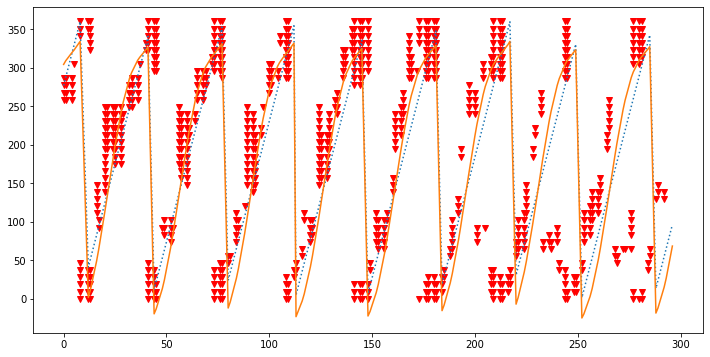

In [257]:
pl.figure(figsize=(12,6))
for i in range(len(dt)):
    pgood=good_angs[i]
    pl.plot(dt[i]*np.ones_like(pgood),pgood,'rv')
pl.plot(dt,phi_max,':')
pl.plot(dt,phi_pred)

In [269]:
imax=sum(np.array(dt)<160)
dt=np.array(dt)
def phi_fun(period,phi0,samp,sphase=90,accel=0):
    phi_max=phi0+360*(dt/period+dt**2*accel)
    phi_max-=360*(phi_max/360).astype(int)
    return phi_max+samp*np.sin(np.deg2rad(phi_max-sphase))

correl=lambda real,simu:np.corrcoef(real,simu)[0][1] if simu.std()>10 else 0
def model(period,phi0,samp,sphase,accel,predict=None):
    if predict==None: predict=predict_roll
    phi_pred=phi_fun(period,phi0,samp,sphase,accel)
    coefs=[]
    for i in range(imax):
        rphi=np.deg2rad(phi_pred[i])
        awee=np.array([np.cos(angle2[i])*np.ones_like(rphi),np.sin(angle2[i])*np.cos(rphi),np.sin(angle2[i])*np.sin(rphi)])# sun dir in EQ frame
        asun=rmatx.T@awee # in body frame
        simu=np.array(predict_roll(asun))
        coefs.append(1-correl(irsens2[:,i],simu))

    return sum(coefs)

pini=[period,phi0,40,140,0]
model(*pini)

39.05309695639043

In [258]:
from scipy.optimize import fmin
pfin=fmin(lambda p:model(*p),pini)

Optimization terminated successfully.
         Current function value: 55.131457
         Iterations: 518
         Function evaluations: 861


In [259]:
pfin

array([3.44373890e+01, 2.87687312e+02, 1.15470690e+01, 1.16049600e+02,
       1.38954747e-06])

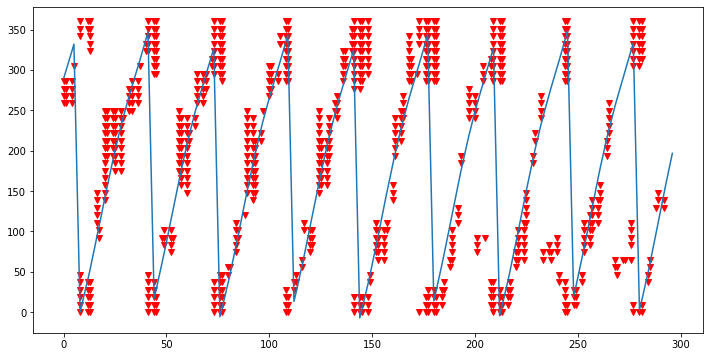

In [260]:
#pfin=[34.17824531, 287.31454935,  29.40824437,  91.28652249,0]
pl.figure(figsize=(12,6))
for i in range(len(dt)):
    pgood=good_angs[i]
    pl.plot(dt[i]*np.ones_like(pgood),pgood,'rv')
#pl.plot(dt,phi_max,':')
pl.plot(dt,phi_fun(*pfin))

In [277]:
imax=len(dt)
#pfin2=fmin(lambda p:model(*p),pfin)
pfin2

amp=3e5
def model2(period,phi0,samp,sphase,accel,mang=75,zex=2.3):
    viewang=lambda ang:(abs(ang)<mang)*(1-(abs(ang)/mang)**zex)*amp
    def predict_roll2(asun):
        xp,xm=viewang(np.rad2deg(np.arccos(asun[0]))),viewang(180-np.rad2deg(np.arccos(asun[0])))
        yp,ym=viewang(np.rad2deg(np.arccos(asun[1]))),viewang(180-np.rad2deg(np.arccos(asun[1])))
        zm=viewang(180-np.rad2deg(np.arccos(asun[2])))
        return xp,yp,xm,ym,zm
    #return model(period,phi0,samp,sphase,accel,predict_roll2)
    phi_pred=phi_fun(period,phi0,samp,sphase,accel)
    coefs=[]
    for i in range(imax):
        rphi=np.deg2rad(phi_pred[i])
        awee=np.array([np.cos(angle2[i])*np.ones_like(rphi),np.sin(angle2[i])*np.cos(rphi),np.sin(angle2[i])*np.sin(rphi)])# sun dir in EQ frame
        asun=rmatx.T@awee # in body frame
        simu=np.array(predict_roll2(asun))
        coefs.append(1-correl(irsens2[:,i],simu))

    return sum(coefs)

pini2=list(pfin2)+[75,2.3]
#model2(*pini2)
pfin3=fmin(lambda p:model2(*p),pini2)

Optimization terminated successfully.
         Current function value: 54.800710
         Iterations: 595
         Function evaluations: 906


In [278]:
pfin3

array([3.44654876e+01, 2.87607043e+02, 1.10766707e+01, 1.25009294e+02,
       1.44935576e-06, 7.30307897e+01, 2.24261374e-01])

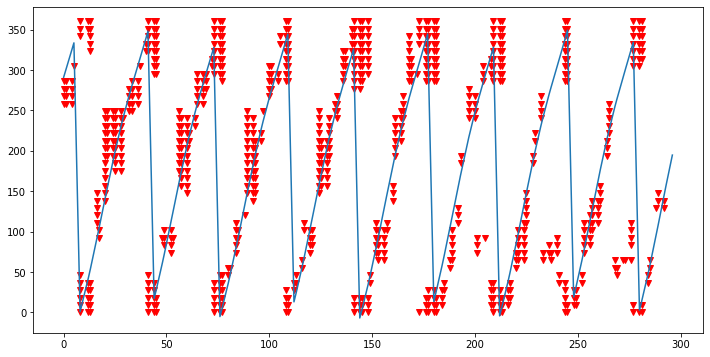

In [280]:
pl.figure(figsize=(12,6))
for i in range(len(dt)):
    pgood=good_angs[i]
    if len(pgood)>0:
        pl.plot(dt[i]*np.ones_like(pgood),pgood,'rv')
    #pl.axvline(dt[i],0,0.5)
#pl.plot(dt,phi_max,':')
pl.plot(dt,phi_fun(*pfin3[:5]))

current best fit:

- period 34.4654876
- phase 287.607043
- ampl 11.0766707
- phase2 125.009294
- period drift/accel 1.44935576e-06
       
$$ampl (1-\left(\frac{|ang|}{ang_{lim}}\right)^{zex})$$

- limit angle 73.0307897 deg, 
- power 0.224261374 (!)

In [1]:
mbody=np.array(mbody)
(mbody**2).sum(1)

NameError: name 'np' is not defined

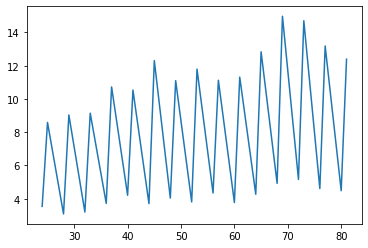

In [288]:
cangs=(mbody[1:,:]*mbody[:-1,:]).sum(1)
pl.plot(dt[1:-2][10:40],np.rad2deg(np.arccos(cangs[10:40])))